Usando dispositivo: cpu
Iniciando preprocesamiento...
Preprocesado Diabetes_012 con One-Hot Encoding. Shape: (13893, 3)
Preprocesado MentHlth con log1p + MinMaxScaler. Shape: (13893, 1)
Preprocesado PhysHlth con log1p + MinMaxScaler. Shape: (13893, 1)
Preprocesado HighBP con MinMaxScaler. Shape: (13893, 1)
Preprocesado HighChol con MinMaxScaler. Shape: (13893, 1)
Preprocesado CholCheck con MinMaxScaler. Shape: (13893, 1)
Preprocesado BMI con MinMaxScaler. Shape: (13893, 1)
Preprocesado Smoker con MinMaxScaler. Shape: (13893, 1)
Preprocesado Stroke con MinMaxScaler. Shape: (13893, 1)
Preprocesado HeartDiseaseorAttack con MinMaxScaler. Shape: (13893, 1)
Preprocesado PhysActivity con MinMaxScaler. Shape: (13893, 1)
Preprocesado Fruits con MinMaxScaler. Shape: (13893, 1)
Preprocesado Veggies con MinMaxScaler. Shape: (13893, 1)
Preprocesado HvyAlcoholConsump con MinMaxScaler. Shape: (13893, 1)
Preprocesado AnyHealthcare con MinMaxScaler. Shape: (13893, 1)
Preprocesado NoDocbcCost con MinMax

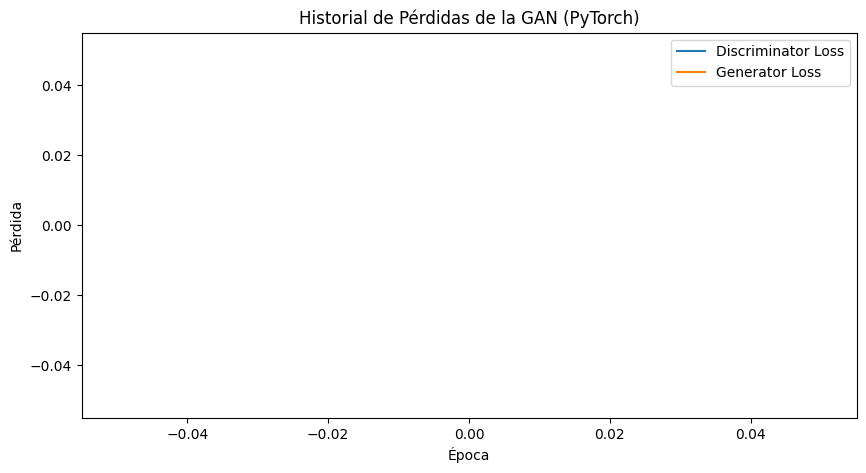


Generando datos sintéticos finales con PyTorch...

Datos sintéticos generados y guardados en: Datasets/generated_data_gan_pytorch.csv

--- Descripción de los datos originales: ---
       Diabetes_012        HighBP      HighChol     CholCheck           BMI  \
count  13893.000000  13893.000000  13893.000000  13893.000000  13893.000000   
mean       1.000000      0.579428      0.561434      0.979342     30.115958   
std        0.816526      0.493669      0.496229      0.142241      7.102212   
min        0.000000      0.000000      0.000000      0.000000     13.000000   
25%        0.000000      0.000000      0.000000      1.000000     25.000000   
50%        1.000000      1.000000      1.000000      1.000000     29.000000   
75%        2.000000      1.000000      1.000000      1.000000     33.000000   
max        2.000000      1.000000      1.000000      1.000000     98.000000   

             Smoker        Stroke  HeartDiseaseorAttack  PhysActivity  \
count  13893.000000  13893.000000 

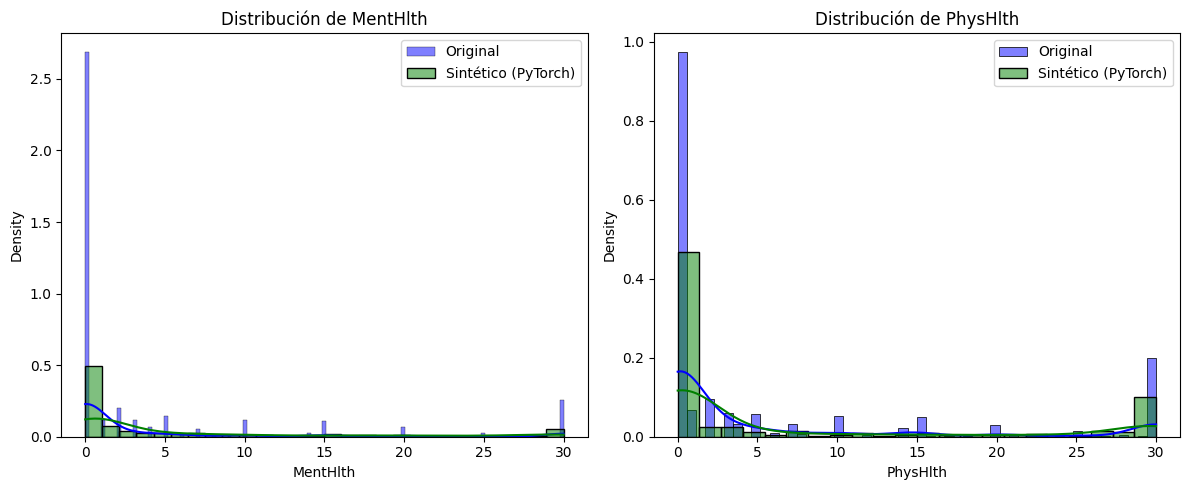


Finalizado con PyTorch.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split # No se usa directamente para GAN

import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset # No se usará DataLoader para este ejemplo simple

# --- 0. Parámetros de la GAN y del Entrenamiento ---
LATENT_DIM = 100
EPOCHS = 1 # Puede necesitar muchas más (ej. 10000-50000+) y ajustes
BATCH_SIZE = 64
SAMPLE_INTERVAL = 1 # Cada cuántas épocas guardar una muestra de datos generados
LEARNING_RATE_G = 0.0002
LEARNING_RATE_D = 0.0002
BETA1 = 0.5 # Parámetro de Adam

# Configurar dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# --- 1. Cargar el archivo CSV original ---
input_file = "Datasets/diabetes_012_health_indicators_BRFSS2015.csv"
data = pd.read_csv(input_file)
class_0 = data[data['Diabetes_012'] == 0].sample(n=4631, random_state=42) 
class_1 = data[data['Diabetes_012'] == 1].sample(n=4631, random_state=42) 
class_2 = data[data['Diabetes_012'] == 2].sample(n=4631, random_state=42) 
data_df = pd.concat([class_0, class_1, class_2]).sample(frac=1, random_state=42).reset_index(drop=True)
original_columns = data_df.columns.tolist()

# --- 2. Preprocesamiento (Igual que antes, usando scikit-learn y numpy) ---
print("Iniciando preprocesamiento...")
processed_data_parts = []
scalers_dict = {}
column_info_for_generator_output = []

special_cols_log_scale = ['MentHlth', 'PhysHlth']
diabetes_col = 'Diabetes_012'

# A. Diabetes_012 (One-Hot Encoding)
#    Para PyTorch, no necesitamos to_categorical de Keras, podemos hacerlo con numpy
num_classes_diabetes = 3
diabetes_one_hot = np.eye(num_classes_diabetes)[data_df[diabetes_col].astype(int)]
processed_data_parts.append(diabetes_one_hot)
column_info_for_generator_output.append({'name': diabetes_col, 'type': 'one_hot', 'num_classes': num_classes_diabetes})
print(f"Preprocesado {diabetes_col} con One-Hot Encoding. Shape: {diabetes_one_hot.shape}")

# B. MentHlth y PhysHlth (log1p + MinMaxScaler)
for col_name in special_cols_log_scale:
    original_values = data_df[col_name].values.reshape(-1, 1)
    log_transformed_values = np.log1p(original_values)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(log_transformed_values)
    processed_data_parts.append(scaled_values)
    scalers_dict[col_name] = {'scaler': scaler, 'log_applied': True, 'original_min': original_values.min(), 'original_max': original_values.max()}
    column_info_for_generator_output.append({'name': col_name, 'type': 'scaled_continuous_sigmoid'})
    print(f"Preprocesado {col_name} con log1p + MinMaxScaler. Shape: {scaled_values.shape}")

# C. Otras columnas (MinMaxScaler para [0,1])
other_cols = [col for col in original_columns if col not in [diabetes_col] + special_cols_log_scale]
for col_name in other_cols:
    original_values = data_df[col_name].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(original_values)
    processed_data_parts.append(scaled_values)
    scalers_dict[col_name] = {'scaler': scaler, 'log_applied': False, 'original_min': original_values.min(), 'original_max': original_values.max()}
    column_info_for_generator_output.append({'name': col_name, 'type': 'scaled_continuous_sigmoid'})
    print(f"Preprocesado {col_name} con MinMaxScaler. Shape: {scaled_values.shape}")

X_train_processed_np = np.concatenate(processed_data_parts, axis=1).astype(np.float32)
DATA_DIM = X_train_processed_np.shape[1]
print(f"Forma final de los datos procesados (X_train_processed_np): {X_train_processed_np.shape}")

# Convertir datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_processed_np, dtype=torch.float32).to(device)


# --- 3. Definir el modelo GAN (PyTorch) ---

class Generator(nn.Module):
    def __init__(self, latent_dim, data_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.BatchNorm1d(256, momentum=0.8),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.BatchNorm1d(512, momentum=0.8),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.BatchNorm1d(1024, momentum=0.8),
            nn.Linear(1024, data_dim),
            nn.Sigmoid() # Salida general en [0,1]
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, data_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid() # Salida binaria (real/falso)
        )

    def forward(self, img):
        return self.model(img)

# Inicializar generador y discriminador
generator = Generator(LATENT_DIM, DATA_DIM).to(device)
discriminator = Discriminator(DATA_DIM).to(device)

# Función de pérdida
adversarial_loss = nn.BCELoss().to(device)

# Optimizadores
optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE_G, betas=(BETA1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_D, betas=(BETA1, 0.999))

print("\n--- Arquitectura del Generador (PyTorch) ---")
print(generator)
print("\n--- Arquitectura del Discriminador (PyTorch) ---")
print(discriminator)


# --- 4. Bucle de Entrenamiento (PyTorch) ---
print("\nIniciando entrenamiento de la GAN con PyTorch...")
d_loss_history = []
g_loss_history = []
d_acc_history = [] # Para la precisión del discriminador

for epoch in range(EPOCHS):
    d_loss_epoch = 0
    g_loss_epoch = 0
    num_batches = X_train_tensor.size(0) // BATCH_SIZE
    for i in range(X_train_tensor.size(0) // BATCH_SIZE): # Iterar sobre batches
        # ---------------------
        #  Entrenar Discriminador
        # ---------------------
        discriminator.train()
        generator.eval() # Generador en modo evaluación para no actualizar sus BN stats aquí

        # Datos reales
        real_imgs = X_train_tensor[i*BATCH_SIZE:(i+1)*BATCH_SIZE].to(device)
        real_labels = torch.ones(real_imgs.size(0), 1, dtype=torch.float32).to(device)
        
        # Datos falsos
        noise = torch.randn(real_imgs.size(0), LATENT_DIM, dtype=torch.float32).to(device)
        fake_imgs = generator(noise)
        fake_labels = torch.zeros(real_imgs.size(0), 1, dtype=torch.float32).to(device)

        # Entrenar con datos reales
        optimizer_D.zero_grad()
        real_output = discriminator(real_imgs)
        d_loss_real = adversarial_loss(real_output, real_labels)
        
        # Entrenar con datos falsos
        fake_output = discriminator(fake_imgs.detach()) # .detach() para no calcular gradientes para G aquí
        d_loss_fake = adversarial_loss(fake_output, fake_labels)
        
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # Calcular precisión del discriminador (opcional)
        # d_accuracy = ((real_output > 0.5).float().sum() + (fake_output < 0.5).float().sum()) / (2 * real_imgs.size(0))


        # ---------------------
        #  Entrenar Generador
        # ---------------------
        generator.train() # Generador en modo entrenamiento
        optimizer_G.zero_grad()
        
        # Generar datos falsos (nuevo batch de ruido)
        noise_g = torch.randn(BATCH_SIZE, LATENT_DIM, dtype=torch.float32).to(device) # Usar BATCH_SIZE fijo para G
        gen_imgs_for_g = generator(noise_g)
        
        # Queremos que el discriminador piense que estos son reales
        # (usamos real_labels que son todos unos)
        # Asegurarse que real_labels_for_g tenga el tamaño correcto si BATCH_SIZE es diferente al último batch de D
        real_labels_for_g = torch.ones(gen_imgs_for_g.size(0), 1, dtype=torch.float32).to(device)
        
        output_g = discriminator(gen_imgs_for_g)
        g_loss = adversarial_loss(output_g, real_labels_for_g)
        
        g_loss.backward()
        optimizer_G.step()

    # Guardar el progreso al final de la época (promedio si se quiere)
    d_loss_history.append(d_loss_epoch / num_batches)
    g_loss_history.append(g_loss_epoch / num_batches)
    # d_acc_history.append(d_accuracy.item())


    if (epoch + 1) % SAMPLE_INTERVAL == 0:
        # print(f"{epoch + 1}/{EPOCHS} [D loss: {d_loss.item():.4f}, acc.: {d_accuracy.item()*100:.2f}%] [G loss: {g_loss.item():.4f}]")
        print(f"{epoch + 1}/{EPOCHS} [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
        # Opcional: Generar y guardar una muestra de datos
        # generator.eval()
        # with torch.no_grad():
        #     noise_sample = torch.randn(5, LATENT_DIM, dtype=torch.float32).to(device)
        #     generated_sample_scaled = generator(noise_sample).cpu().numpy()
        #     print("Generated sample (scaled, PyTorch): \n", generated_sample_scaled[:2])
        # generator.train()


# --- Graficar historial de pérdidas ---
plt.figure(figsize=(10, 5))
plt.plot(d_loss_history, label='Discriminator Loss')
plt.plot(g_loss_history, label='Generator Loss')
plt.title("Historial de Pérdidas de la GAN (PyTorch)")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.savefig("gan_loss_history_pytorch.png")
plt.show()


# --- 5. Generación y Postprocesamiento de Datos Finales (PyTorch) ---
print("\nGenerando datos sintéticos finales con PyTorch...")
#num_samples_to_generate = 1000 # Esto determina la cantidad de datos sintéticos a generar broders
num_samples_per_class = 1000  # Number of samples you want for each class
num_classes = 3
total_samples_needed = num_samples_per_class * num_classes
extra_factor = 2

generator.eval() # Modo evaluación
synthetic_df_final = pd.DataFrame()
all_generated_data_scaled = []
generation_batch_size = 512

num_to_generate = total_samples_needed * extra_factor

# Generar en batches si num_samples_to_generate es muy grande para evitar OOM
with torch.no_grad():
    for i in range(0, num_to_generate, generation_batch_size):
        current_batch_size = min(generation_batch_size, num_to_generate - i)
        if current_batch_size <= 0:
            break
        noise_final_batch = torch.randn(current_batch_size, LATENT_DIM, dtype=torch.float32).to(device)
        generated_batch_scaled = generator(noise_final_batch).cpu().numpy()
        all_generated_data_scaled.append(generated_batch_scaled)

generated_data_scaled_final_np = np.concatenate(all_generated_data_scaled, axis=0)


current_col_idx_in_generated = 0
for col_info in column_info_for_generator_output:
    col_name = col_info['name']
    col_type = col_info['type']

    if col_type == 'one_hot':
        num_classes = col_info['num_classes']
        one_hot_part = generated_data_scaled_final_np[:, current_col_idx_in_generated : current_col_idx_in_generated + num_classes]
        diabetes_pred = np.argmax(one_hot_part, axis=1)
        synthetic_df_final[col_name] = diabetes_pred
        current_col_idx_in_generated += num_classes

    elif col_type == 'scaled_continuous_sigmoid':
        generated_values_scaled = generated_data_scaled_final_np[:, current_col_idx_in_generated : current_col_idx_in_generated + 1]
        current_col_idx_in_generated += 1
        
        s_info = scalers_dict[col_name]
        scaler_obj = s_info['scaler']
        inverted_values = scaler_obj.inverse_transform(generated_values_scaled)
        
        if s_info['log_applied']:
            inverted_values = np.expm1(inverted_values)
        if data_df[col_name].dtype == 'int64' or (data_df[col_name].dtype == 'float64' and np.all(data_df[col_name] == data_df[col_name].astype(int))):
            final_values = np.round(inverted_values)
        else:
            final_values = inverted_values
        
        final_values = np.clip(final_values, s_info['original_min'], s_info['original_max'])
        synthetic_df_final[col_name] = final_values.flatten().astype(data_df[col_name].dtype)

synthetic_df_final = synthetic_df_final[original_columns]

balanced_synthetic = []
for class_value in range(num_classes):
    class_samples = synthetic_df_final[synthetic_df_final['Diabetes_012'] == class_value]
    balanced_synthetic.append(class_samples.sample(n=num_samples_per_class, replace=True, random_state=42))
synthetic_df_final_balanced = pd.concat(balanced_synthetic).sample(frac=1, random_state=42).reset_index(drop=True)

output_file_pytorch = "Datasets/generated_data_gan_pytorch.csv"
synthetic_df_final_balanced.to_csv(output_file_pytorch, index=False)
print(f"\nDatos sintéticos generados y guardados en: {output_file_pytorch}")

# --- Mostrar algunas estadísticas de los datos generados (igual que antes) ---
print("\n--- Descripción de los datos originales: ---")
print(data_df.describe())
print("\n--- Descripción de los datos sintéticos (PyTorch): ---")
print(synthetic_df_final_balanced.describe())

print("\n--- Conteo de valores para Diabetes_012 (Original): ---")
print(data_df['Diabetes_012'].value_counts(normalize=True).sort_index())
print("\n--- Conteo de valores para Diabetes_012 (Sintético - PyTorch): ---")
print(synthetic_df_final_balanced['Diabetes_012'].value_counts(normalize=True).sort_index())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data_df['MentHlth'], ax=axes[0], color='blue', label='Original', kde=True, stat="density")
sns.histplot(synthetic_df_final_balanced['MentHlth'], ax=axes[0], color='green', label='Sintético (PyTorch)', kde=True, stat="density")
axes[0].set_title('Distribución de MentHlth')
axes[0].legend()

sns.histplot(data_df['PhysHlth'], ax=axes[1], color='blue', label='Original', kde=True, stat="density")
sns.histplot(synthetic_df_final_balanced['PhysHlth'], ax=axes[1], color='green', label='Sintético (PyTorch)', kde=True, stat="density")
axes[1].set_title('Distribución de PhysHlth')
axes[1].legend()

plt.tight_layout()
plt.savefig("generated_data_distributions_comparison_pytorch.png")
plt.show()

print("\nFinalizado con PyTorch.")